## Importing Packages

In [1]:
import numpy as np
import pandas as pd
import cmdstanpy 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import os
import json

from scipy.stats import gaussian_kde
import ipywidgets as widgets

In [2]:
sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.use14corefonts'] = True

## Choose Model

#### roots and global variables

In [3]:
root = './'
plots_root = root + 'Plots/'
datasets_root = root + 'Datasets/'
behavioural_data_root = root +  'behavioral_data/selected_data/' 
stan_files_root = root +  'stan files/' 
saved_models_root = root + 'stan_results/'

model_config = {}
plots_path = ''
dataset_path = ''
stan_file_path = ''
stan_output_dir = ''

#### read models configuration json file

In [4]:
with open("rdm_models.json") as f:
    models = json.load(f)
    models_name = list(models.keys())

#### Choose and set model configuration

In [5]:
def SetModelAndPaths(model_name):
    global model_config
    global plots_path
    global dataset_path
    global stan_file_path
    global stan_output_dir
    model_config = models[model_name]
    plots_path = plots_root + model_config['plots_folder_name'] + '/'
    dataset_path = datasets_root + model_config['dataset_name']
    stan_file_path = stan_files_root + model_config['stan_file']
    stan_output_dir = saved_models_root + model_config['model_name'] + '/'
    os.path
    
    if not os.path.exists(plots_path):
        os.makedirs(plots_path)
        print("Directory " , plots_path ,  " Created ")
    else:    
        print("Directory " , plots_path ,  " already exists")
        
    if not os.path.exists(stan_output_dir):
        os.makedirs(stan_output_dir)
        print("Directory " , stan_output_dir ,  " Created ")
    else:    
        print("Directory " , stan_output_dir ,  " already exists")

widgets.interact(SetModelAndPaths, model_name=models_name);

interactive(children=(Dropdown(description='model_name', options=('RDM', 'RDM_ct', 'RDM_cd', 'RDM_ndm', 'ANN-R…

In [6]:
model_config

{'model_name': 'ANN-RDM_full_FC',
 'stan_file': 'ANN-RDM/sigmoid_am_ndm.stan',
 'dataset_name': 'fastText_FC.csv',
 'plots_folder_name': 'ANN-RDM_full_FC',
 'transf_params': ['transf_mu_alpha',
  'transf_mu_b',
  'transf_mu_threshold_word',
  'transf_mu_threshold_nonword',
  'transf_mu_g',
  'transf_mu_m',
  'transf_mu_k_1',
  'transf_mu_k_2']}

## Prepare data

Loading words and non-words with zipf and predicted probabilities

In [7]:
word_nword_df = pd.read_csv(dataset_path, header=None, names =['string', 'freq',  'label', 'zipf','category', 'word_prob', 'non_word_prob'])
word_nword_df

,string,freq,label,zipf,category,word_prob,non_word_prob
0,thashbuckler,0,0,0.000000,NW,2.327570e-03,0.997672
1,citad,0,0,0.000000,NW,1.029650e-05,0.999990
2,recipus,0,0,0.000000,NW,5.357853e-05,0.999946
3,imducted,0,0,0.000000,NW,1.005859e-07,1.000000
4,suy,0,0,0.000000,NW,9.614917e-06,0.999990
...,...,...,...,...,...,...,...
74312,stave,253,1,2.547107,LF,9.991799e-01,0.000820
74313,lonclusions,0,0,0.000000,NW,8.465163e-05,0.999915
74314,profing,0,0,0.000000,NW,1.867627e-03,0.998132
74315,utbeknownst,0,0,0.000000,NW,5.369962e-03,0.994630


In [8]:
# Reading LDT Data
behavioural_df = pd.read_csv(behavioural_data_root + 'LDT_data_test.csv',
                             header=None,
                             names=['accuracy', 'rt', 'string', 'response',
                                    'participant', 'minRT', 'participant_id'])
# Merging  behavioral dataframe with word_nonword_df to have words and non-words data with behavioral data
behavioural_df = pd.merge(behavioural_df, word_nword_df, on='string', how='left').dropna().reset_index(drop=True)
behavioural_df = behavioural_df.drop(["freq", "participant"], axis=1)

In [9]:
behavioural_df.head()

,accuracy,rt,string,response,minRT,participant_id,label,zipf,category,word_prob,non_word_prob
0,1,0.502,stunt,1,0.362,1,1.0,3.963932,HF,1.000000,9.581844e-08
1,1,0.577,elastic,1,0.362,1,1.0,3.024228,HF,0.999999,8.020173e-07
2,1,0.518,now,1,0.362,1,1.0,6.504911,HF,0.998521,1.479349e-03
3,0,0.543,vaitresses,1,0.362,1,0.0,0.000000,NW,0.000027,9.999728e-01
4,1,0.556,sweetness,1,0.362,1,1.0,3.517143,HF,0.999987,1.260954e-05


Predicted probabilities of words and non-words in different conditions in all trials
across participants

In [10]:
behavioural_df.groupby(['category']).agg({'word_prob': ['mean', 'std', 'count', 'max', 'min'],
                                          'non_word_prob': ['mean', 'std', 'count', 'max', 'min']})

word_prob                                         non_word_prob  \
              mean       std count       max           min          mean   
category                                                                   
HF        0.993052  0.052480   359  1.000000  1.060254e-01      0.006948   
LF        0.989829  0.044395   488  1.000000  4.929332e-01      0.010171   
NW        0.007959  0.069925   994  0.990711  5.867976e-12      0.992041   

                                                  
               std count       max           min  
category                                          
HF        0.052480   359  0.893975  5.177446e-11  
LF        0.044395   488  0.507067  4.941905e-09  
NW        0.069925   994  1.000000  9.288552e-03

RT and response description of words and non-words in different conditions in all trials
across participants

In [11]:
behavioural_df.groupby(['category']).agg({'rt': ['mean', 'std', 'max', 'min'],
                                          'response': ['mean', 'std', 'max', 'min']})

rt                          response                  
              mean       std    max    min      mean       std max min
category                                                              
HF        0.706532  0.259814  2.003  0.216  0.949861  0.218537   1   0
LF        0.855375  0.300717  2.165  0.200  0.807377  0.394764   1   0
NW        0.882127  0.311168  2.226  0.203  0.135815  0.342764   1   0

## Stan Model and Estimation

Compiling stan model

In [15]:
rdm_model = cmdstanpy.CmdStanModel(model_name=model_config['model_name'],
                                   stan_file=stan_file_path)

18:03:51 - cmdstanpy - INFO - compiling stan file E:\Workspace\Thesis\ANN-EAM\stan files\ANN-RDM\sigmoid_am_ndm.stan to exe file E:\Workspace\Thesis\ANN-EAM\stan files\ANN-RDM\sigmoid_am_ndm.exe
18:04:36 - cmdstanpy - INFO - compiled model executable: E:\Workspace\Thesis\ANN-EAM\stan files\ANN-RDM\sigmoid_am_ndm.exe
18:04:36 - cmdstanpy - WARNING - Stan compiler has produced 24 warnings:
18:04:36 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/Arash/AppData/Local/Temp/tmp6_tba34j/tmpj1xjjvaq.hpp C:/Users/Arash/AppData/Local/Temp/tmp6_tba34j/tmpj1xjjvaq.stan
Warning in 'C:/Users/Arash/AppData/Local/Temp/tmp6_tba34j/tmpj1xjjvaq.stan', line 55, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'C:/Users/Arash/AppData/Local/Temp

Preparing model's inputs

note that some inputs of data_dict might not be used depending on which model is used

In [17]:
N = len(behavioural_df)                                                    # For all models
participant = behavioural_df['participant_id'].to_numpy()                     # For all models
p = behavioural_df.loc[:, ['word_prob', 'non_word_prob']].to_numpy()       # predicted probabilites of words and non-words, for ANN-EAM models
frequency = behavioural_df['zipf'].to_numpy().astype(int)                  # zipf values, for models with non-decision time or drift modulation
frequencyCondition = behavioural_df['category'].replace(["HF", "LF", "NW"], [1, 2, 3]).to_numpy() # For models with conditional drift
response = behavioural_df['response'].to_numpy().astype(int)               # for all models
rt = behavioural_df['rt'].to_numpy()                                       # for all models
minRT = behavioural_df['minRT'].to_numpy()                                 # for all models
RTbound = 0.1                                                              # for all models
Number_Of_Participants = len(set(behavioural_df['participant_id']))

threshold_priors = [0, 1, 1, 1]          # For all models with LBA
ndt_priors = [0, 1, 1, 1];               # For models wtihout non-decision time modulation
g_priors = [-2, 1, 0, 1]                 # For models wtih non-decision time modulation
m_priors = [0, 0.5, 0, 1]                # For models wtih non-decision time modulation
drift_priors = [1, 2, 1, 1]              # For models without drift mapping functions (non ANN-EAM models)
alpha_priors = [0, 1, 1, 1]              # For models with drift mapping functions
b_priors = [0, 1, 1, 1]                  # For models with drift mapping functions with asymptote modulation and linear models
k_priors = [2, 1, 1, 1]                  # For models with sigmoid drift mapping functions (ANN-EAM models)

# define input for the model
data_dict = {'N': N,
             'L': Number_Of_Participants,
             'participant': participant,
             'response': response,
             'rt': rt,
             'minRT': minRT,
             'RTbound': RTbound,
             'frequency': frequency,
             'frequencyCondition': frequencyCondition,
             'threshold_priors': threshold_priors,
             'ndt_priors': ndt_priors,
             'g_priors': g_priors,
             'm_priors': m_priors,
             'drift_priors': drift_priors,
             'p': p,
             'alpha_priors': alpha_priors,
             'b_priors': b_priors,
             'k_priors': k_priors,
             }

# set sampling parameters
n_iter = 500
n_warmup = int(n_iter/2)
n_sample = int(n_iter/2)
n_chains = 2

Fitting the model

In [18]:
fit = rdm_model.sample(data=data_dict,
                       iter_sampling=n_sample, 
                       iter_warmup=n_warmup,
                       chains=n_chains,
                       output_dir=stan_output_dir,
                       show_console=True)

18:06:10 - cmdstanpy - INFO - Chain [1] start processing
18:06:10 - cmdstanpy - INFO - Chain [2] start processing


Chain [2] method = sample (Default)
Chain [2] sample
Chain [1] method = sample (Default)
Chain [2] num_samples = 250
Chain [2] num_warmup = 250
Chain [2] save_warmup = 0 (Default)
Chain [2] thin = 1 (Default)
Chain [2] adapt
Chain [2] engaged = 1 (Default)
Chain [2] gamma = 0.050000000000000003 (Default)
Chain [2] delta = 0.80000000000000004 (Default)
Chain [2] kappa = 0.75 (Default)
Chain [2] t0 = 10 (Default)
Chain [2] init_buffer = 75 (Default)
Chain [2] term_buffer = 50 (Default)
Chain [2] window = 25 (Default)
Chain [2] algorithm = hmc (Default)
Chain [2] hmc
Chain [1] sample
Chain [1] num_samples = 250
Chain [1] num_warmup = 250
Chain [1] save_warmup = 0 (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [1] gamma = 0.050000000000000003 (Default)
Chain [1] delta = 0.80000000000000004 (Default)
Chain [2] engine = nuts (Default)
Chain [2] nuts
Chain [2] max_depth = 10 (Default)
Chain [2] metric = diag_e (Default)
Chain [2] metric_file =  (D

18:10:20 - cmdstanpy - INFO - Chain [2] done processing


Chain [2] 
Chain [2] Elapsed Time: 141.736 seconds (Warm-up)
Chain [2] 108.634 seconds (Sampling)
Chain [2] 250.37 seconds (Total)
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 


18:10:27 - cmdstanpy - INFO - Chain [1] done processing
18:10:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: tmpj1xjjvaq_model_namespace::log_prob: drift_word_t[4] is nan, but must be greater than or equal to 0.000000 (in 'C:/Users/Arash/AppData/Local/Temp/tmp6_tba34j/tmpj1xjjvaq.stan', line 115, column 4 to column 36)
	Exception: tmpj1xjjvaq_model_namespace::log_prob: drift_word_t[4] is nan, but must be greater than or equal to 0.000000 (in 'C:/Users/Arash/AppData/Local/Temp/tmp6_tba34j/tmpj1xjjvaq.stan', line 115, column 4 to column 36)
	Exception: tmpj1xjjvaq_model_namespace::log_prob: drift_word_t[4] is nan, but must be greater than or equal to 0.000000 (in 'C:/Users/Arash/AppData/Local/Temp/tmp6_tba34j/tmpj1xjjvaq.stan', line 115, column 4 to column 36)
	Exception: tmpj1xjjvaq_model_namespace::log_prob: drift_word_t[4] is nan, but must be greater than or equal to 0.000000 (in 'C:/Users/Arash/AppData/Local/Temp/tmp6_tba34j/tmpj1xjjvaq.stan', line 115, column

Chain [1] 
Chain [1] Elapsed Time: 150.967 seconds (Warm-up)
Chain [1] 106.45 seconds (Sampling)
Chain [1] 257.417 seconds (Total)
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 


Loading Model

(In case model have been fitted before)

In [12]:
# fit = cmdstanpy.from_csv(stan_output_dir)

## Model diagnostics

In [19]:
print("***hmc diagnostics:")
print(fit.diagnose(), flush=True)

***hmc diagnostics:
Processing csv files: E:\Workspace\Thesis\ANN-EAM\stan_results\ANN-RDM_full_FC\ANN-RDM_full_FC-20230304180610_1.csv, E:\Workspace\Thesis\ANN-EAM\stan_results\ANN-RDM_full_FC\ANN-RDM_full_FC-20230304180610_2.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [20]:
df = fit.summary()

print("***DF: ")
df

***DF: 


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-755.609000,0.622299,6.780430,-766.833000,-755.449000,-744.568000,118.718,0.551962,1.002280
mu_g,-3.555280,0.026776,0.718822,-4.742650,-3.541190,-2.452920,720.678,3.350680,1.001530
mu_m,-0.437656,0.022407,0.412195,-1.081730,-0.427477,0.262886,338.408,1.573380,0.999984
mu_threshold_word,1.215280,0.027519,0.332400,0.645490,1.249470,1.712710,145.902,0.678348,1.027390
mu_threshold_nonword,1.611870,0.025401,0.348413,0.951557,1.672440,2.079610,188.146,0.874754,1.007890
...,...,...,...,...,...,...,...,...,...
log_lik[1837],-3.272770,0.010034,0.274448,-3.738560,-3.266820,-2.850270,748.063,3.478000,0.996071
log_lik[1838],-2.087430,0.006292,0.170132,-2.385220,-2.084130,-1.818500,731.170,3.399460,0.996316
log_lik[1839],-3.058720,0.008876,0.216354,-3.409370,-3.048900,-2.690250,594.163,2.762470,1.002600
log_lik[1840],-2.208330,0.006654,0.180246,-2.519600,-2.203420,-1.925700,733.755,3.411480,0.996219


In [21]:
counter = 0
print("***Rhat > 1.01: ")
for f in df["R_hat"]:
    if f >= 1.01 or f <= 0.9:
        counter+=1
print(counter)

***Rhat > 1.01: 
29


In [22]:
df.loc[df['R_hat']>1.01].to_csv('logs/'+model_config['model_name']+'_rhat_log.csv')

In [23]:
df.loc[df['R_hat']>1.01]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
mu_threshold_word,1.215280,0.027519,0.332400,0.645490,1.249470,1.712710,145.902000,0.678348,1.027390
sd_threshold_word,0.742591,0.023368,0.377962,0.329396,0.641986,1.478310,261.620000,1.216360,1.013890
z_threshold_word[1],-0.201452,0.031465,0.509971,-1.041480,-0.169516,0.582949,262.692000,1.221350,1.012750
z_threshold_word[3],-0.764305,0.046039,0.605036,-1.765570,-0.729386,0.120695,172.706000,0.802968,1.020550
transf_mu_threshold_word,1.485101,0.020422,0.248221,1.067090,1.501520,1.878540,147.740876,0.686898,1.024987
log_lik[411],0.298644,0.004321,0.081773,0.163221,0.301150,0.427427,358.187000,1.665330,1.010440
log_lik[419],0.266727,0.004491,0.084859,0.125534,0.268329,0.402823,356.987000,1.659760,1.010430
log_lik[421],0.317197,0.004323,0.079978,0.183708,0.320476,0.446246,342.273000,1.591340,1.010370
log_lik[1384],-0.194233,0.002630,0.063304,-0.306516,-0.193518,-0.094113,579.489000,2.694250,1.011010
log_lik[1399],-0.321724,0.002787,0.062082,-0.427348,-0.320481,-0.220327,496.160000,2.306820,1.013810


In [24]:
df.loc[df['R_hat']>1.01].describe()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,0.065801,0.007714,0.119691,-0.127517,0.067555,0.255779,325.750375,1.514526,1.013196
std,0.470101,0.010930,0.147616,0.508268,0.467061,0.556052,97.564901,0.453614,0.004109
min,-0.764305,0.002630,0.050312,-1.765570,-0.729386,-0.577583,145.902000,0.678348,1.010370
25%,-0.167090,0.002892,0.050445,-0.252176,-0.166065,-0.061766,290.922000,1.352600,1.011120
50%,0.064667,0.002986,0.052832,-0.022299,0.065096,0.157713,311.694000,1.449170,1.011910
75%,0.186789,0.004321,0.079978,0.102292,0.187957,0.270485,342.273000,1.591340,1.013200
max,1.485101,0.046039,0.605036,1.067090,1.501520,1.878540,579.489000,2.694250,1.027390


## Check parameters

Parameters posterior plots

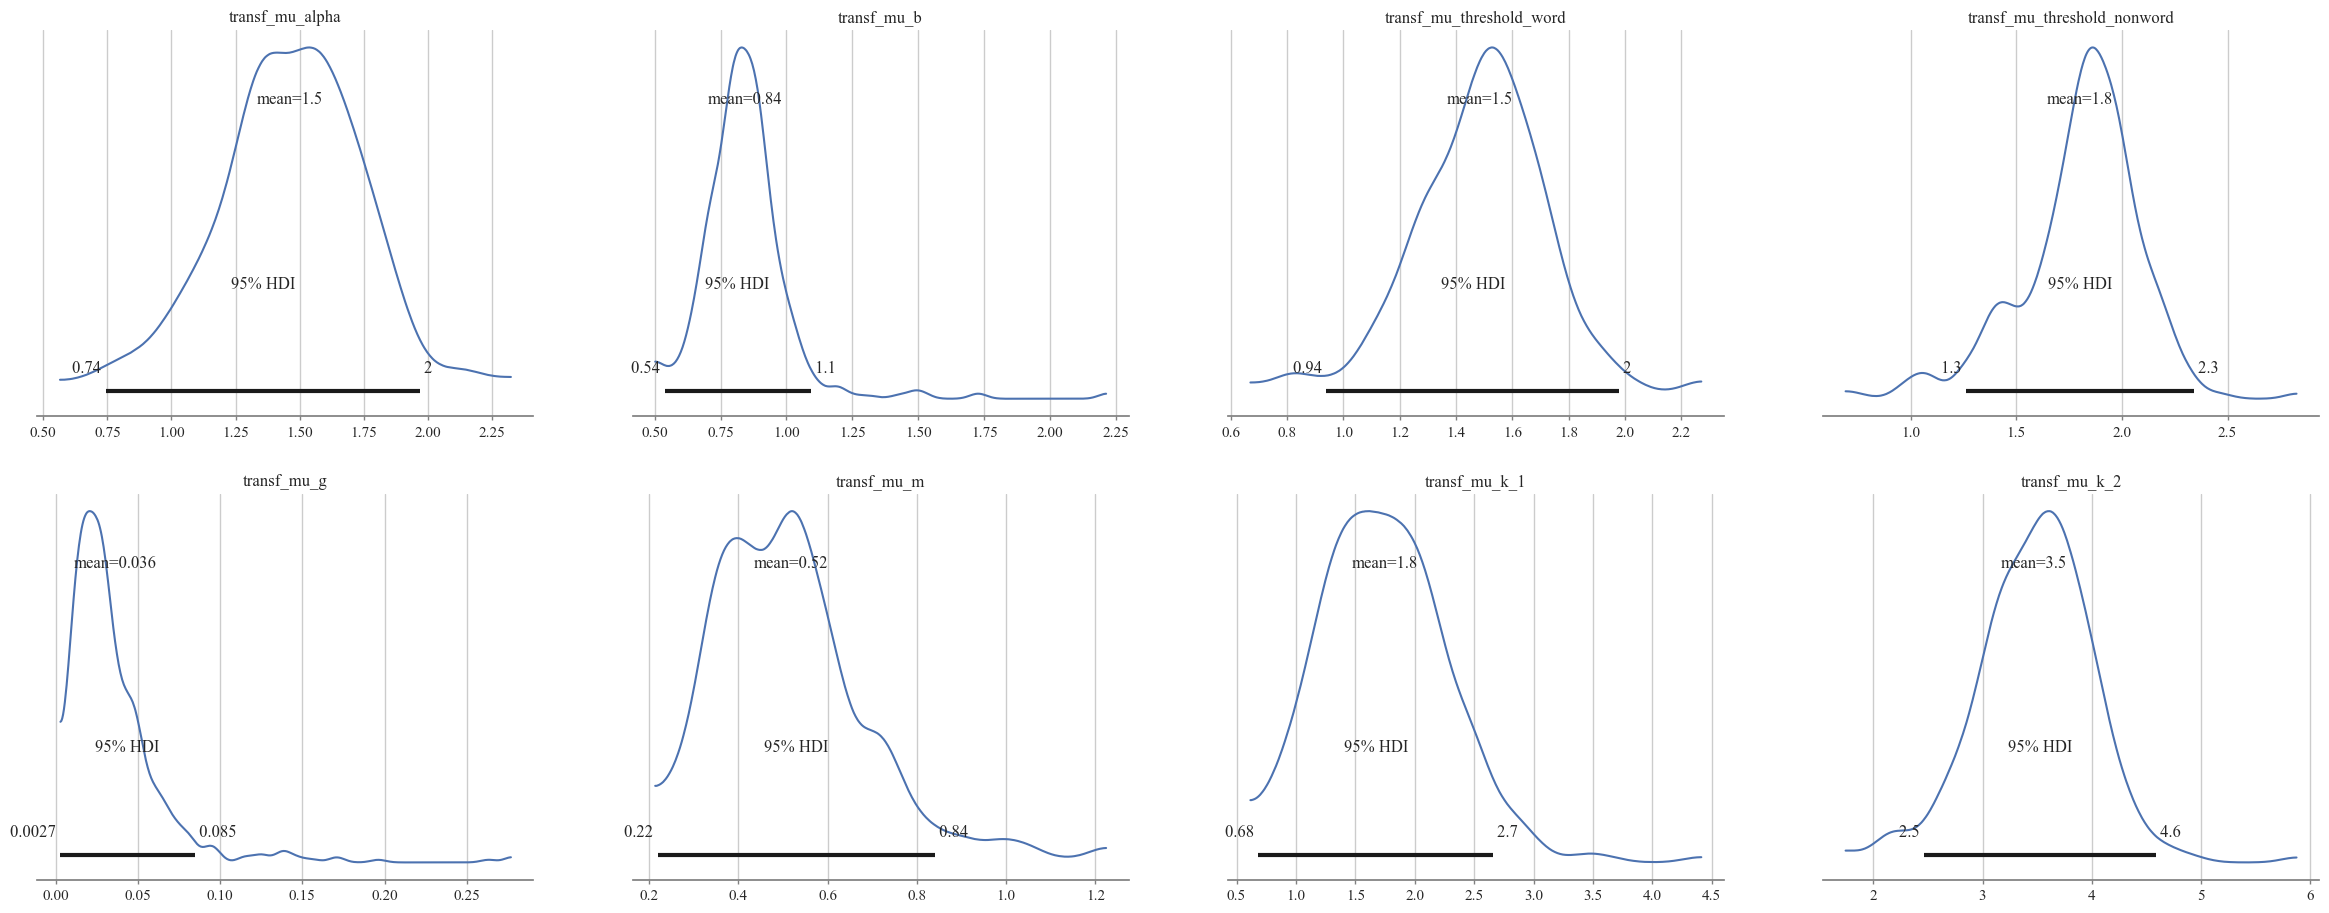

In [13]:
az.plot_posterior(fit, var_names=model_config['transf_params'], hdi_prob=.95);
plt.savefig(plots_path + 'Parameters.pdf')

Loading model parameters for each trial

In [14]:
drift_word_t = fit.stan_variables()['drift_word_t']
drift_nonword_t = fit.stan_variables()['drift_nonword_t']
if model_config['model_name'] != "RDM":
    threshold_t_word = fit.stan_variables()['threshold_t_word']
    threshold_t_nonword = fit.stan_variables()['threshold_t_nonword']
else:
    threshold_t = fit.stan_variables()['threshold_t']
ndt_t = fit.stan_variables()['ndt_t']

#### Models mean parameters in different conditions

In [15]:
HF_condition_w = drift_word_t[:, behavioural_df['category']=="HF"]
HF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="HF"]
LF_condition_w = drift_word_t[:, behavioural_df['category']=="LF"]
LF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="LF"]
NW_condition_w = drift_word_t[:, behavioural_df['category']=="NW"]
NW_condition_nw = drift_nonword_t[:, behavioural_df['category']=="NW"]

In [16]:
print('HF words, word drift mean and std:')
print(np.mean(np.mean(HF_condition_w, axis=1)), np.std(np.mean(HF_condition_w, axis=1)))
print('HF words, nonword drift mean and std:')
print(np.mean(np.mean(HF_condition_nw, axis=1)), np.std(np.mean(HF_condition_nw, axis=1)))
print('LF words word drift mean and std:')
print(np.mean(np.mean(LF_condition_w, axis=1)), np.std(np.mean(LF_condition_w, axis=1)))
print('LF words nonword drift mean and std:')
print(np.mean(np.mean(LF_condition_nw, axis=1)), np.std(np.mean(LF_condition_nw, axis=1)))
print('NW words word drift mean and std:')
print(np.mean(np.mean(NW_condition_w, axis=1)), np.std(np.mean(NW_condition_w, axis=1)))
print('NW words nonword drift mean and std:')
print(np.mean(np.mean(NW_condition_nw, axis=1)), np.std(np.mean(NW_condition_nw, axis=1)))

HF words, word drift mean and std:
3.086394720835655 0.09969371870478674
HF words, nonword drift mean and std:
1.2243459260334262 0.10382077535938375
LF words word drift mean and std:
2.2258997060655736 0.09120550853865399
LF words nonword drift mean and std:
1.2142449756762295 0.1075403801146798
NW words word drift mean and std:
0.5768590358652113 0.07420834973175246
NW words nonword drift mean and std:
2.657493376022133 0.08112713368151751


In [17]:
if model_config['model_name'] != "RDM":
    HF_condition_w = threshold_t_word[:, behavioural_df['category']=="HF"]
    HF_condition_nw = threshold_t_nonword[:, behavioural_df['category']=="HF"]
    LF_condition_w = threshold_t_word[:, behavioural_df['category']=="LF"]
    LF_condition_nw = threshold_t_nonword[:, behavioural_df['category']=="LF"]
    NW_condition_w = threshold_t_word[:, behavioural_df['category']=="NW"]
    NW_condition_nw = threshold_t_nonword[:, behavioural_df['category']=="NW"]
else:
    HF_condition = threshold_t[:, behavioural_df['category']=="HF"]
    LF_condition = threshold_t[:, behavioural_df['category']=="LF"]
    NW_condition = threshold_t[:, behavioural_df['category']=="NW"]

In [18]:
if model_config['model_name'] != "RDM":
    print('HF words, word threshold mean and std:')
    print(np.mean(np.mean(HF_condition_w, axis=1)), np.std(np.mean(HF_condition_w, axis=1)))
    print('HF words, nonword threshold mean and std:')
    print(np.mean(np.mean(HF_condition_nw, axis=1)), np.std(np.mean(HF_condition_nw, axis=1)))
    print('LF words word threshold mean and std:')
    print(np.mean(np.mean(LF_condition_w, axis=1)), np.std(np.mean(LF_condition_w, axis=1)))
    print('LF words nonword threshold mean and std:')
    print(np.mean(np.mean(LF_condition_nw, axis=1)), np.std(np.mean(LF_condition_nw, axis=1)))
    print('NW words word threshold mean and std:')
    print(np.mean(np.mean(NW_condition_w, axis=1)), np.std(np.mean(NW_condition_w, axis=1)))
    print('NW words nonword threshold mean and std:')
    print(np.mean(np.mean(NW_condition_nw, axis=1)), np.std(np.mean(NW_condition_nw, axis=1)))
else:
    print('HF words, threshold mean and std:')
    print(np.mean(np.mean(HF_condition, axis=1)), np.std(np.mean(HF_condition, axis=1)))
    print('LF words, threshold mean and std:')
    print(np.mean(np.mean(LF_condition, axis=1)), np.std(np.mean(LF_condition, axis=1)))
    print('NW words, word threshold mean and std:')
    print(np.mean(np.mean(NW_condition, axis=1)), np.std(np.mean(NW_condition, axis=1)))

HF words, word threshold mean and std:
1.5889066470752091 0.06497705020146685
HF words, nonword threshold mean and std:
1.92045008 0.07398518200097474
LF words word threshold mean and std:
1.5982299855327875 0.06998243137044813
LF words nonword threshold mean and std:
1.9357284061885245 0.08011201937355016
NW words word threshold mean and std:
1.6013772346478883 0.06686604591499859
NW words nonword threshold mean and std:
1.9350313402816908 0.07650205299220206


In [19]:
HF_condition = ndt_t[:, behavioural_df['category']=="HF"]
LF_condition = ndt_t[:, behavioural_df['category']=="LF"]
NW_condition = ndt_t[:, behavioural_df['category']=="NW"]

In [20]:
print('HF words ndt_t mean and std:')
print(np.mean(np.mean(HF_condition, axis=1)), np.std(np.mean(HF_condition, axis=1)))
print('LF words ndt_t mean and std:')
print(np.mean(np.mean(LF_condition, axis=1)), np.std(np.mean(LF_condition, axis=1)))
print('Non Words ndt_t mean and std:')
print(np.mean(np.mean(NW_condition, axis=1)), np.std(np.mean(NW_condition, axis=1)))

HF words ndt_t mean and std:
0.19480484719220056 0.011896763727935305
LF words ndt_t mean and std:
0.20549948417622946 0.013025994209718393
Non Words ndt_t mean and std:
0.20617501284909462 0.013139926497219928


## Calculating metrics

In [21]:
def calculate_waic(log_likelihood, pointwise=False):
    """
    Returns model comparisions' metrics.
    
    Parameters
    ----------
        log_likelihood: np.array
            log_likelihood of each trial
        max_rt: float
            maximum acceptable rt
        min_rt: float
             minimum acceptable rt
             
    Optional Parameters
    ----------------
    pointwise: float
        if true pointwise waic will be calculated
        
    Returns
    -------
        out:  a dictionary containing lppd, waic, waic_se and pointwise_waic    
    """
    likelihood = np.exp(log_likelihood)

    mean_l = np.mean(likelihood, axis=0) # N observations

    pointwise_lppd = np.log(mean_l)
    lppd = np.sum(pointwise_lppd)

    pointwise_var_l = np.var(log_likelihood, axis=0) # N observations
    var_l = np.sum(pointwise_var_l)

    pointwise_waic = - 2*pointwise_lppd +  2*pointwise_var_l
    waic = -2*lppd + 2*var_l
    waic_se = np.sqrt(log_likelihood.shape[1] * np.var(pointwise_waic))

    if pointwise:
        out = {'lppd':lppd,
               'p_waic':var_l,
               'waic':waic,
               'waic_se':waic_se,
               'pointwise_waic':pointwise_waic}
    else:
        out = {'lppd':lppd,
               'p_waic':var_l,
                'waic':waic,
                'waic_se':waic_se}
    return out

In [22]:
log_likelihood = fit.stan_variables()['log_lik']
print(calculate_waic(log_likelihood))

{'lppd': -707.4767217457385, 'p_waic': 38.227723280582964, 'waic': 1491.4088900526428, 'waic_se': 100.59127901269667}


## Simulating RDM with estimated parameters

In [23]:
def random_rdm_2A(cor_drift, inc_drift, threshold_word, threshold_nonword, ndt, noise_constant=1, dt=0.001, max_rt=10):
    """ 
    Simulates behavior (rt and accuracy) according to the Racing Diffusion Model.
     
    Parameters
    ----------
    cor_drift : numpy.ndarray
        Drift-rate of the Racing Diffusion Model - correct trials.
    inc_drift : numpy.ndarray
        Drift-rate of the Racing Diffusion Model - incorrect trials.
    threshold : numpy.ndarray
        Shape is usually (n_samples, n_trials).
        Threshold of the diffusion decision model.
    ndt : numpy.ndarray
        Shape is usually (n_samples, n_trials).
        Non decision time of the diffusion decision model, in seconds.
    
    Optional Parameters
    ----------------
    noise_constant : float, default 1
        Scaling factor of the Racing Diffusion Model.
        If changed, drift and threshold would be scaled accordingly.
        Not to be changed in most applications.
    dt : float, default 0.001
        Controls the time resolution of the Racing Diffusion Model. Default is 1 msec.
        Lower values of dt make the function more precise but much slower.
    max_rt : float, default 10
        Controls the maximum rts that can be predicted.
        Making this higher might make the function a bit slower.
    
    Returns
    -------
    rt : numpy.ndarray
        Shape is the same as the input parameters.
        Contains simulated response times according to the Racing Diffusion Model.
        Every element corresponds to the set of parameters given as input with the same shape.
    acc: numpy.ndarray
        Shape is the same as the input parameters.
        Contains simulated accuracy according to the Racing Diffusion Model.
        Every element corresponds to the set of parameters given as input with the same shape.
    """
    shape = cor_drift.shape
    acc = np.empty(shape)
    rt = np.empty(shape)
    acc[:] = np.nan
    rt[:] = np.nan

    max_tsteps = max_rt/dt

    x_cor = np.zeros(shape)
    x_inc = np.zeros(shape)

    tstep = 0
    ongoing = np.array(np.ones(shape), dtype=bool)

    stop_race = False

    while np.sum(ongoing) > 0 and tstep < max_tsteps:
        x_cor[ongoing] += np.random.normal(cor_drift[ongoing]*dt,
                                           noise_constant*np.sqrt(dt),
                                           np.sum(ongoing))
        x_inc[ongoing] += np.random.normal(inc_drift[ongoing]*dt,
                                           noise_constant*np.sqrt(dt),
                                           np.sum(ongoing))
        tstep += 1
        ended_correct = (x_cor >= threshold_word)
        ended_incorrect = (x_inc >= threshold_nonword)

        # store results and filter out ended trials
        if np.sum(ended_correct) > 0:
            acc[np.logical_and(ended_correct, ongoing)] = 1
            rt[np.logical_and(ended_correct, ongoing)] = dt*tstep + ndt[np.logical_and(ended_correct, ongoing)]
            ongoing[ended_correct] = False

        if np.sum(ended_incorrect) > 0:
            acc[np.logical_and(ended_incorrect, ongoing)] = 0
            rt[np.logical_and(ended_incorrect, ongoing)] = dt*tstep + ndt[np.logical_and(ended_incorrect, ongoing)]
            ongoing[ended_incorrect] = False
    return rt, acc

Simulating RDM with estimated parameters

In [24]:
if model_config['model_name'] != "RDM":
    pp_rt, pp_response = random_rdm_2A(drift_word_t, drift_nonword_t, threshold_t_word, threshold_t_nonword, ndt_t, noise_constant=1, dt=0.001, max_rt=5)
else:
    pp_rt, pp_response = random_rdm_2A(drift_word_t, drift_nonword_t, threshold_t, threshold_t, ndt_t, noise_constant=1, dt=0.001, max_rt=5)

In [25]:
def bci(x, alpha=0.05):
    """
    Calculate Bayesian credible interval (BCI).
    
    Parameters
    ----------
    x : array-like
        An array containing MCMC samples.
    
    Optional Parameters
    -------------------
    alpha : float, default 0.05
        Desired probability of type I error.
    
    Returns
    -------
    interval : numpy.ndarray
        Array containing the lower and upper bounds of the bci interval.
    """
    interval = np.nanpercentile(x, [(alpha/2)*100, (1-alpha/2)*100])

    return interval

In [26]:
# Predicted Data
rt_predictions = pd.concat((pd.DataFrame(pp_rt, index=pd.Index(np.arange(1, len(pp_rt)+1))).T, behavioural_df['category']), axis=1)
response_predictions = pd.concat((pd.DataFrame(pp_response, index=pd.Index(np.arange(1, len(pp_response)+1))).T, behavioural_df['category']), axis=1)

# Experiment Data
experiment_data = behavioural_df.loc[:, ['rt', 'response', 'category']]

Separating RT and Response of predicted and experimental data for each condition

In [27]:
HF_data = experiment_data.loc[experiment_data['category']=='HF']
LF_data = experiment_data.loc[experiment_data['category']=='LF']
NW_data = experiment_data.loc[experiment_data['category']=='NW']

HF_pred_rt = rt_predictions.loc[rt_predictions['category']=='HF'].drop(['category'], axis=1)
HF_pred_resp = response_predictions.loc[response_predictions['category']=='HF'].drop(['category'], axis=1)
LF_pred_rt = rt_predictions.loc[rt_predictions['category']=='LF'].drop(['category'], axis=1)
LF_pred_resp = response_predictions.loc[response_predictions['category']=='LF'].drop(['category'], axis=1)
NW_pred_rt = rt_predictions.loc[rt_predictions['category']=='NW'].drop(['category'], axis=1)
NW_pred_resp = response_predictions.loc[response_predictions['category']=='NW'].drop(['category'], axis=1)

## Quantiles Posterior Predictions

In [28]:
quantiles = [.1, .3, .5, .7, .9]
percentiles = np.array(quantiles)*100

In [29]:
# experiment Data quantile
HF_quantile_ex = HF_data['rt'].quantile(quantiles)
LF_quantile_ex = LF_data['rt'].quantile(quantiles)
NW_quantile_ex = NW_data['rt'].quantile(quantiles)

# predicted data quantiles (for each sample)
HF_quantile_pred = HF_pred_rt.quantile(quantiles, axis=0).T
LF_quantile_pred = LF_pred_rt.quantile(quantiles, axis=0).T
NW_quantile_pred = NW_pred_rt.quantile(quantiles, axis=0).T

# predicted data quantiles bci
HF_predicted_bci = np.array([bci(HF_quantile_pred[x]) for x in quantiles])
LF_predicted_bci = np.array([bci(LF_quantile_pred[x]) for x in quantiles])
NW_predicted_bci = np.array([bci(NW_quantile_pred[x]) for x in quantiles])

C:\Users\Arash\AppData\Local\Temp\ipykernel_3148\1342134211.py:34: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(16)
C:\Users\Arash\AppData\Local\Temp\ipykernel_3148\1342134211.py:36: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(16)


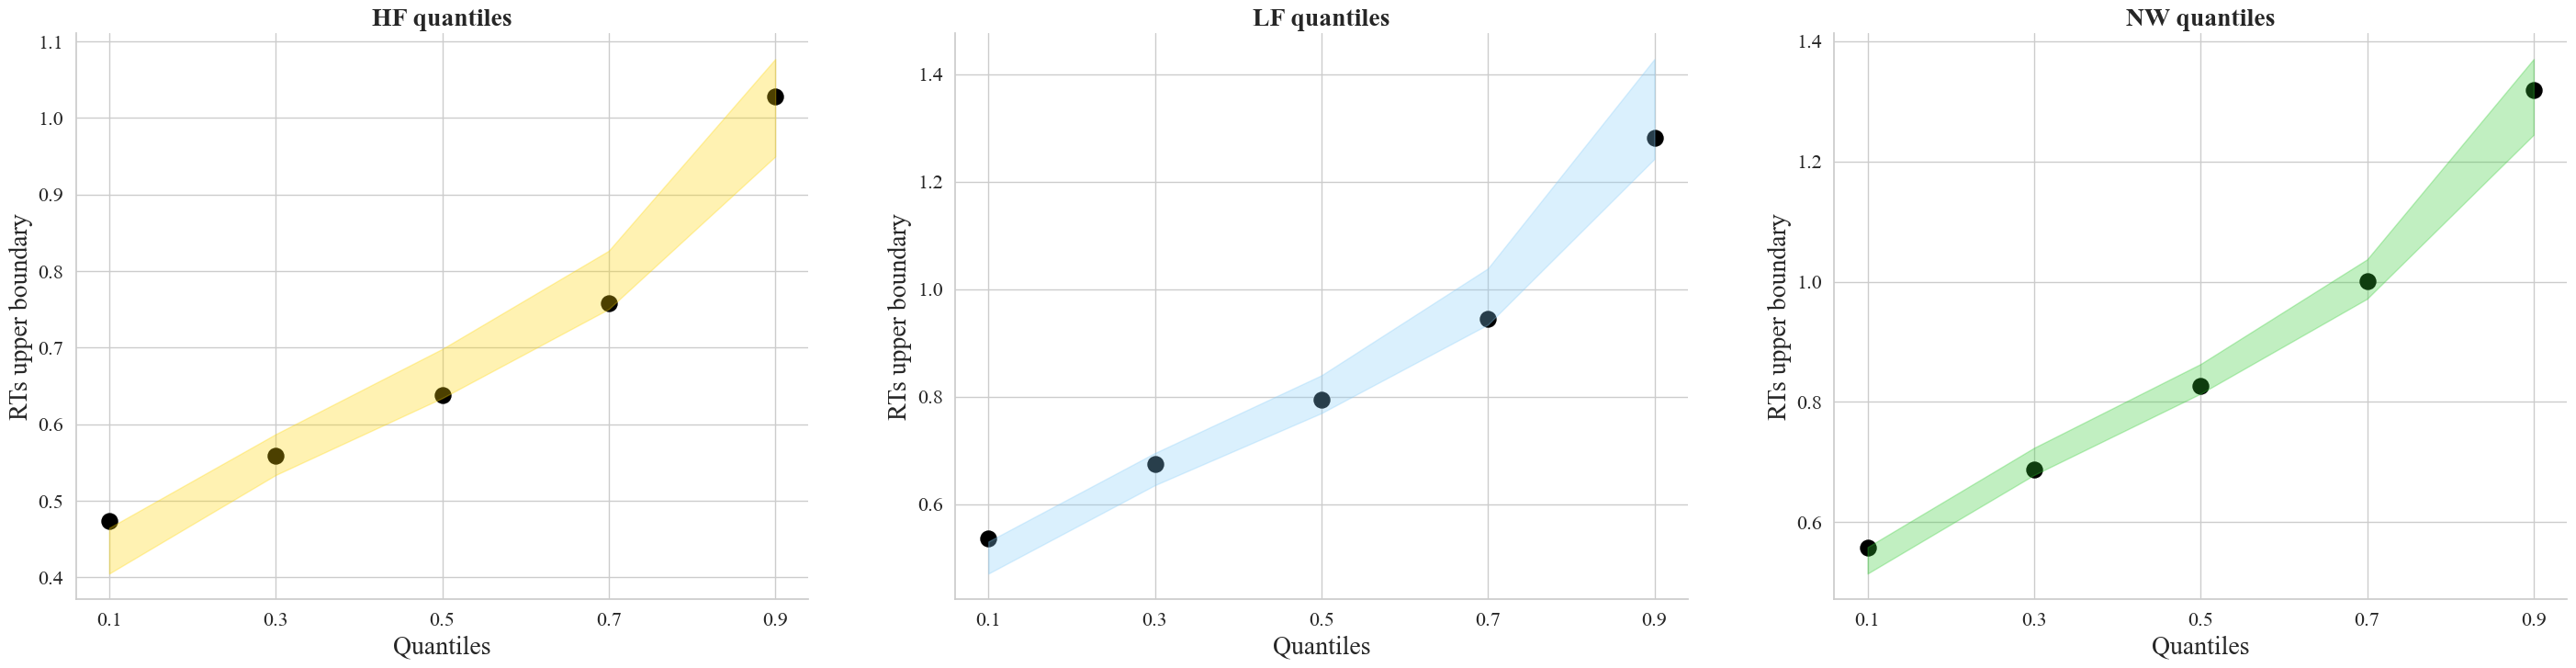

In [30]:
fig, axes = plt.subplots(1,3 , figsize=(35,8))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes[0].set_title('HF quantiles', fontweight="bold", size=20)
axes[1].set_title('LF quantiles', fontweight="bold", size=20)
axes[2].set_title('NW quantiles', fontweight="bold", size=20)

axes[0].scatter(quantiles, HF_quantile_ex, color='black', s=150)
axes[1].scatter(quantiles, LF_quantile_ex, color='black', s=150)
axes[2].scatter(quantiles, NW_quantile_ex, color='black', s=150)

axes[0].fill_between(quantiles,
                HF_predicted_bci[:, 0],
                HF_predicted_bci[:, 1],
                HF_predicted_bci[:, 0] < HF_predicted_bci[:, 1],  color = 'gold', alpha=0.3)

axes[1].fill_between(quantiles,
                LF_predicted_bci[:, 0],
                LF_predicted_bci[:, 1],
                LF_predicted_bci[:, 0] < LF_predicted_bci[:, 1],  color = 'lightskyblue', alpha=0.3)

axes[2].fill_between(quantiles,
                NW_predicted_bci[:, 0],
                NW_predicted_bci[:, 1],
                NW_predicted_bci[:, 0] < NW_predicted_bci[:, 1],  color = 'limegreen', alpha=0.3)


for ax in axes:
        ax.set_xlabel('Quantiles', fontsize=20)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel('RTs upper boundary', fontsize=20)
        for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(16)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(16) 

sns.despine()
plt.savefig(plots_path + 'Quantiles Poseterior.pdf')

## Mean Accuracy and RT Posterior Plots

In [31]:
HF_data_rt_mean = HF_data['rt'].mean()
LF_data_rt_mean = LF_data['rt'].mean()
NW_data_rt_mean = NW_data['rt'].mean()

HF_pred_rt_mean = HF_pred_rt.mean(axis=0)
LF_pred_rt_mean = LF_pred_rt.mean(axis=0)
NW_pred_rt_mean = NW_pred_rt.mean(axis=0)


HF_data_resp_mean = HF_data['response'].mean()
LF_data_resp_mean = LF_data['response'].mean()
NW_data_resp_mean = NW_data['response'].mean()

HF_pred_resp_mean = HF_pred_resp.mean(axis=0)
LF_pred_resp_mean = LF_pred_resp.mean(axis=0)
NW_pred_resp_mean = NW_pred_resp.mean(axis=0)


In [32]:
def plot_posterior(x, data_mean, ax):
    """
    Plots the posterior of x with experimental data mean as a line
    
    Parameters
    ----------
    x : array-like
        An array containing RT or response for each trial.
        
    x : float
        mean of RT or Accuracy of experimental data.

    ax : matplotlib.axes.Axes
        
    Returns
    -------
    None
    """
    density = gaussian_kde(x, bw_method='scott')
    xd = np.linspace(x.min(), x.max())
    yd = density(xd)

    low, high = bci(x)
    ax.fill_between(xd[np.logical_and(xd >= low, xd <= high)],
                     yd[np.logical_and(xd >= low, xd <= high)], color = 'lightsteelblue')

    ax.plot(xd, yd, color='slategray')
    ax.axvline(data_mean, color='red')

C:\Users\Arash\AppData\Local\Temp\ipykernel_3148\102435654.py:26: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(13)
C:\Users\Arash\AppData\Local\Temp\ipykernel_3148\102435654.py:28: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(13)
C:\Users\Arash\AppData\Local\Temp\ipykernel_3148\102435654.py:30: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(13)
C:\Users\Arash\AppData\Local\Temp\ipykernel_3148\102435654.py:32: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(13)


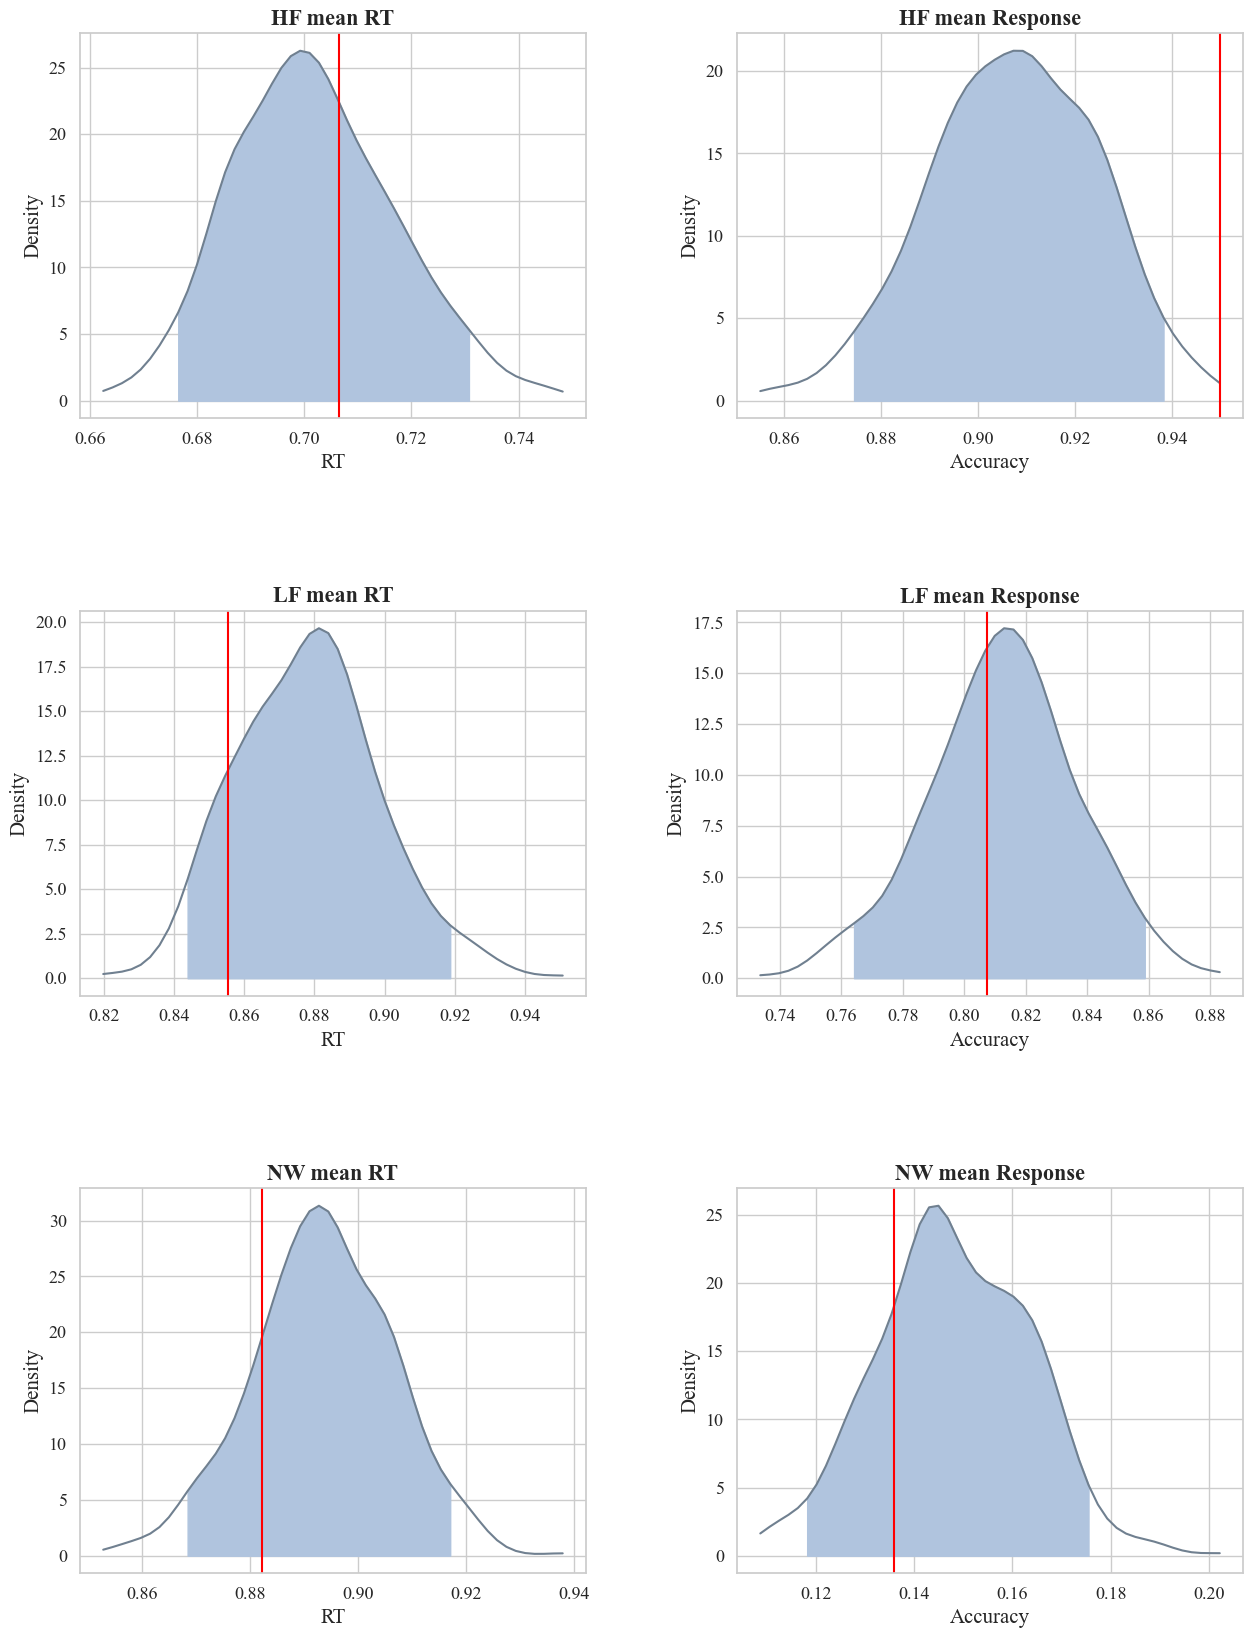

In [33]:
fig, axes = plt.subplots(3,2 , figsize=(15,20))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

axes[0][0].set_title('HF mean RT', fontweight="bold", size=16)
axes[0][1].set_title('HF mean Response', fontweight="bold", size=16)
axes[1][0].set_title('LF mean RT', fontweight="bold", size=16)
axes[1][1].set_title('LF mean Response', fontweight="bold", size=16)
axes[2][0].set_title('NW mean RT', fontweight="bold", size=16)
axes[2][1].set_title('NW mean Response', fontweight="bold", size=16)

plot_posterior(HF_pred_rt_mean, HF_data_rt_mean, axes[0][0])
plot_posterior(HF_pred_resp_mean, HF_data_resp_mean, axes[0][1])

plot_posterior(LF_pred_rt_mean, LF_data_rt_mean, axes[1][0])
plot_posterior(LF_pred_resp_mean, LF_data_resp_mean, axes[1][1])

plot_posterior(NW_pred_rt_mean, NW_data_rt_mean, axes[2][0])
plot_posterior(NW_pred_resp_mean, NW_data_resp_mean, axes[2][1])

for ax in axes:
        ax[0].set_xlabel('RT', fontsize=15)
        ax[1].set_xlabel('Accuracy', fontsize=15)
        ax[0].set_ylabel('Density', fontsize=15)
        ax[1].set_ylabel('Density', fontsize=15)
        for tick in ax[0].xaxis.get_major_ticks():
                tick.label.set_fontsize(13)
        for tick in ax[0].yaxis.get_major_ticks():
            tick.label.set_fontsize(13)
        for tick in ax[1].xaxis.get_major_ticks():
            tick.label.set_fontsize(13)
        for tick in ax[1].yaxis.get_major_ticks():
            tick.label.set_fontsize(13) 

plt.savefig(plots_path + 'Mean Accuracy and RT.pdf')